Jack Chak, Thi Giang, Steven Rogalsky

In this Jupyter notebook, you will find the code to the Wordle game and the Solver for the game.

In addition, you will need to have a `data` folder containing the files `CSW19.txt` and `freq_map.json`.  In the same folder as this file, you will need to have the file `common_words.py`.  These can be found in the included .zip file.

After some online research, we found that the official Wordle game bases its allowed input off the Scrabble word list, found in `data/CSW19.txt`.  The first order of business is to reduce this list to just 5 letter words:

In [1]:
input = open('data/CSW19.txt')
out = open('data/CSW19-5.txt', 'w')

out.write("".join([line for line in input if len(line.strip()) == 5]))

input.close()
out.close()

Next, we implement the Wordle game that our solver will interface with.  The solver (or a user) will interact with this API by creating a new `Game` instance, and it will take turns using the `evaluate_guess` function.  After each turn, the game will return the turn outcome (success or failure), as well as a list which contains the color for each letter. The game also has methods to check its status, number of guesses, and the word.

The game supports playing in easy mode - that is, for each turn, the user may enter any combination of letters as long as it is a valid 5-letter word in the dictionary.

Additionally, when the user creates a game, they may supply a word for the game, but if not the word will be chosen randomly from the list of `common_words`.  This is the list of 2000+ words found in Wordle source, which contains the official words used in the game.

In [28]:
import random as random
from common_words import common_words
input = open('data/CSW19-5.txt')

class Game:
  __all_words = [line.strip().lower() for line in input]
  def __init__(self, word = None, max_guesses = 6):
    self.__max_guesses = max_guesses
    self.__guesses = 0
    self.__status = 'in progress'
    if not word:
      self.__word = self.__choose_random_start()
    else:
      if word.lower() not in self.__all_words:
        print('Word must be in dictionary')
        return
      self.__word = word

  def __choose_random_start(self):
    return common_words[random.randint(0, len(common_words)-1)].lower()

  def get_status(self):
    return self.__status

  def get_guesses(self):
    return self.__guesses

  def get_word(self):
    if self.get_status() == 'in progress':
      print("Game is still in progress, don't cheat!")
      return None
    return self.__word

  def evaluate_guess(self, guess):
    lower_guess = guess.lower()
    # validation checks
    if self.__status != 'in progress':
      return { 'outcome': 'fail', 'reason': 'Game is over'}
    if lower_guess not in self.__all_words:
      return { 'outcome': 'fail', 'reason': 'Word is not in dictionary'}
    self.__guesses += 1

    answer_array = list(self.__word)
    guess_array = list(lower_guess)

    # To evaluate guess, match all green letters first, then yellow letters

    # initialize all feedback to gray
    feedback = [(letter, 'gray') for letter in guess_array]

    # check for greens
    for idx, letter in enumerate(guess_array):
      if self.__word[idx] == letter: # add green
        feedback[idx] = (letter, 'green')
        answer_array[idx] = None # remove from answer array
        guess_array[idx] = '-' # Don't evaluate this one again

    # check for yellows
    for idx, letter in enumerate(guess_array):
      if letter in answer_array:
        feedback[idx] = (letter, 'yellow')
        answer_array[answer_array.index(letter)] = None # remove from answer array
        guess_array[idx] = '-' # remove from guess array

    # win
    if [outcome for (letter, outcome) in feedback] == ['green', 'green', 'green', 'green', 'green']:
      self.__status = 'win'
     # loss
    elif self.__guesses >= self.__max_guesses:
      self.__status = 'loss'
    return { 'outcome': 'success', 'status': self.__status, 'feedback': feedback }

Note: this code is required for the section following it, so it may make sense to skip to that first and then come back here.

For the solver's method of choosing a word based on word score, we add an optimization to adjust it by the word's frequency.  When generating a score, we determine weights using two methods:

1.  'Eyeball' a cutoff point where common words seem to taper off.  For all the words above this point, assign weights of 1.  For all words below this point, assign weights of 0.1.
1.  Make the wieght of a word a linear function of its frequency rank.  Common words will receive scores closer to 1, while uncommon words will receive scores closer to 0.

In [30]:
import json

with open('./data/freq_map.json') as json_file:
    data = json.load(json_file)

sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=True)

# method 1: assign weights using a percentile cutoff
percentile = 0.35 # ADJUST the cutoff point
quantile = int(percentile*len(sorted_data))
freq_data = {word: 1 for (word, freq) in sorted_data[:quantile]}
reduced = {word: 0.1 for (word, freq) in sorted_data[quantile:]} # ADJUST the weight
freq_data.update(reduced)

# method 2: assign weights linearly by order
scaled_data = {word: (len(sorted_data) - index)/len(sorted_data) for (index, (word, freq)) in enumerate(sorted_data)}

Next, we implement the solver.  The solver has several methods for choosing a word and we experiment with them to optimize its ability.  For all methods, the solver will use the feedback it receives after a turn from the game and use it to reduce the list of target words. From its list of target words, it makes a choice:

- Method 1: Naively choose the first word in the list of target words
- Method 2: Choose the next word from target words based on frequency of English words. For frequency we use `freq_map.json` obtained from [3blue1brown's project](https://github.com/3b1b/videos/tree/master/_2022/wordle/data)
- Method 3: Choose the next word that will affect the most number of target words.  This calculates scores for each letter, and then chooses a word with highest score.  Note that we don't score duplicate letters when getting a word score.
  - Iteration 1: Weigh all letters the same
  - Iteration 2: Weigh the letters using `freq_data` (see above code block)
  - Iteration 3: Weigh the letters using `scaled_data` (see above code block)
- Method 4: Use Method 3 for the first 4 turns, and Method 4 thereafter.

In [48]:
from common_words import common_words
import json
from freq_map_cutoff import freq_data, scaled_data

input = open('data/CSW19-5.txt')
all_words = [line.strip().lower() for line in input]
with open('./data/freq_map.json') as json_file:
    data = json.load(json_file)

# Reduce the list of eligible words based off feedback in the previous turn
def filter_words(eligible_words, feedback):
    eligible = eligible_words
    # filter words with green matches
    for (position, letter_feedback) in enumerate(feedback):
        (letter, color) = letter_feedback
        if(color == 'green'):
            eligible = { word: [None if i == position else l for i, l in enumerate(letters)] for (word, letters) in eligible.items() if letters[position] == letter}

    # filter based on yellows
    for (position, letter_feedback) in enumerate(feedback):
        (letter, color) = letter_feedback
        if(color == 'yellow'):
            new_eligible = {}
            for (word, letters) in eligible.items():
                if letter in letters and letters[position] != letter:
                    letters[letters.index(letter)] = None
                    new_eligible[word] = letters
            eligible = new_eligible

    # filter based on grays
    for (position, letter_feedback) in enumerate(feedback):
        (letter, color) = letter_feedback
        if(color == 'gray'):
            eligible = { word: letters for (word, letters) in eligible.items() if letter not in letters}
    return eligible

# based on frequency of remaining letters
def get_word_by_letter_freq(potential_words, past_guesses):
    letter_counts = {}
    multipliers = scaled_data
    # multipliers = freq_data ADJUST
    for word in potential_words:
        multiplier = multipliers[word]
        for letter in word:
            letter_counts[letter] = letter_counts.get(letter, 0)+multiplier # ADJUST multiplier = 1
    # get letters we've guessed already
    guessed_letters = []
    for guess in past_guesses:
        for (letter, color) in guess:
            guessed_letters.append(letter)
    guessed_letters = list(set(guessed_letters))
    # remove letters we've already guessed
    for letter in guessed_letters:
        if letter in letter_counts:
            del letter_counts[letter]

    # for each potential word, get a freq score
    scores = { word: sum([letter_counts.get(letter, 0) for letter in set(list(word))])*multipliers[word] for word in potential_words } # ADJUST multiplier
    # choose word with max score
    (word, count) = sorted(scores.items(), key=lambda x: x[1], reverse=True)[0]

    return word

# based on frequency in english dictionary
def get_word_by_freq(potential_words):
    better_words = {word: data[word] for word in potential_words}
    better_words = sorted(better_words.items(), key=lambda x: x[1], reverse=True)
    (guess, frequencies) = better_words[0]
    return guess


def play_game(starting_word = None, show_output = False):
    game = Game()
    potential_words = {word: list(word) for word in all_words}
    guesses = []
    last_turn = None
    while game.get_status() == 'in progress':
        show_output and print(f'DOING TURN {game.get_guesses()+1}')
        potential_words = {word: list(word) for word in potential_words.keys()} # reset
        if last_turn and last_turn['feedback']:
            potential_words = filter_words(potential_words, last_turn['feedback'])
        if starting_word and game.get_guesses() == 0:
            guess = starting_word
        else:
            #
            # Here is where we can ADJUST the choosing method
            # We want to try different strategies and compare the results
            #
            # Naive method - choose first word remaining
            # guess = list(potential_words.keys())[0]
            #
            # Choose based on English word frequency
            # guess = get_word_by_freq(list(potential_words.keys()))
            #
            # Choose based on remaining letter frequency (maximize words selected)
            # guess = get_word_by_letter_freq(list(potential_words.keys()), guesses)
            #
            # Do a hybrid approach:
            if game.get_guesses() < 4:
                guess = get_word_by_letter_freq(list(potential_words.keys()), guesses)
            else:
                guess = get_word_by_freq(list(potential_words.keys()))
        show_output and print(f'Guessing {guess}')
        last_turn = game.evaluate_guess(guess)
        if last_turn['outcome'] == 'success':
            guesses.append(last_turn['feedback'])
        else: 
            # try again with another word
            show_output and print(last_turn['reason'])
            guess = potential_words[0]

    if(show_output):
        if game.get_status() == 'win':
            print(f'Woohoo, \U0001F973 we won in {game.get_guesses()} turns with word {guess}')
        elif game.get_status() == 'loss':
            print(f'Noooo \U0001F616 we lost after {game.get_guesses()} turns')
            print(f'The word was {game.get_word()}')
            print(f'The guesses were {guesses}')
        else:
            print(f'\U0001F450 I don\'t know what happened')
        
    return game


We can see what the output looks like when the solver plays one round of the game.

In [5]:
play_game(show_output=True)

DOING TURN 1
Guessing rates
DOING TURN 2
Guessing noise
DOING TURN 3
Guessing sidle
DOING TURN 4
Guessing siege
DOING TURN 5
Guessing sieve
Woohoo, 🥳 we won in 5 turns with word sieve


To test the different algorithms and to optimize, we run many trials of the solver playing the game.  From that, we calculate win rate and average number of turns.

Note that we don't yet have controls in `simulate` to test the different algorithms. You'll need to adjust in the solver code above at the points where `ADJUST` is mentioned in the comments.

In [27]:

# Simulate a number of games being played, and get the results
def simulate(trials = 1000, starting_word = None, show_output = False):
    wins = 0
    total_guesses = 0
    for i in range(0,trials):
        game = play_game(starting_word, show_output)
        if game.get_status() == 'win':
            wins += 1
        total_guesses += game.get_guesses()

    p_wins = wins/trials
    print(f'Won {p_wins*100}% of {trials} games, averaging {total_guesses/trials} guesses per game')
    return p_wins

simulate(trials = 1000)

Won 98.68% of 5000 games, averaging 3.8768 guesses per game


0.9868

In [45]:
import pandas as pd
# Results from 5000 trials with different algorithms
percentage=[82.18, 93.12,97.24,96.6, 96.62,98.68]
average_guess=[5.0272, 4.3996,3.9048,4.0118,4.3406,3.8768]
method=['Naive first choice','Letter freq, no weights',
        'Letter freq, linearly weighted','Letter freq, binary weighted',
        'English word freq','Hybrid']
data=pd.DataFrame({'method': method, 'winning_percentage': percentage, 'average_guess': average_guess})

(80.0, 100.0)

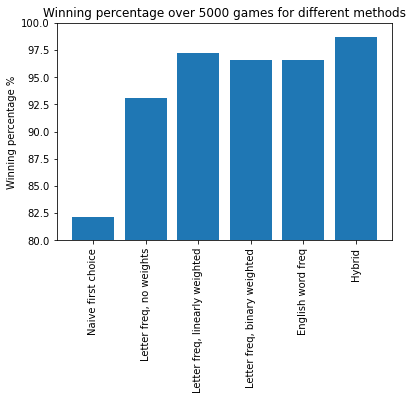

In [46]:
import numpy as np
import matplotlib.pyplot as plt

plt.bar(np.arange(len(method)),data.winning_percentage);
plt.xticks(range(0,6),method, rotation=90);
plt.title('Winning percentage over 5000 games for different methods');
plt.ylabel('Winning percentage %')
plt.ylim([80, 100])

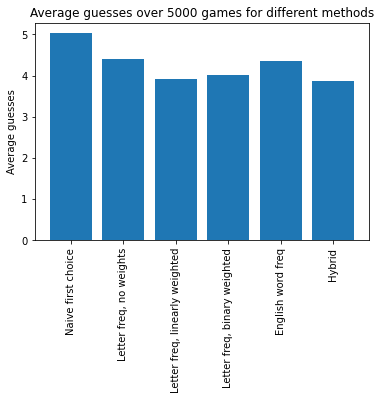

In [47]:
plt.bar(np.arange(len(method)),data.average_guess);
plt.xticks(range(0,6),method, rotation=90);
plt.title('Average guesses over 5000 games for different methods');
plt.ylabel('Average guesses');